# ***Data Collection & Preparation***

In [ ]:
import yfinance as yf
btc_ticker = yf.Ticker("BTC-USD")
btc = btc_ticker.history(period="max")
btc=btc[['Close','Volume']]
btc['Target'] = btc['Close'].shift(-1)
btc.loc[btc.index[-1], 'Target'] = None
btc

,Close,Volume,Target
Date,,,
2014-09-17 00:00:00+00:00,457.334015,21056800,424.440002
2014-09-18 00:00:00+00:00,424.440002,34483200,394.795990
2014-09-19 00:00:00+00:00,394.795990,37919700,408.903992
2014-09-20 00:00:00+00:00,408.903992,36863600,398.821014
2014-09-21 00:00:00+00:00,398.821014,26580100,402.152008
...,...,...,...
2024-03-12 00:00:00+00:00,71481.289062,62554434520,73083.500000
2024-03-13 00:00:00+00:00,73083.500000,48212536929,71396.593750
2024-03-14 00:00:00+00:00,71396.593750,59594605698,69403.773438


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
def create_sequences(df, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df['Close'].iloc[i:i + window_size].values)
        y.append(df['Target'].iloc[i + window_size])
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(btc, window_size)
print(X.shape,y.shape)

(3439, 30) (3439,)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler()
X_normalized = scaler_x.fit_transform(X)
scaler_y = StandardScaler()
y_normalized = scaler_y.fit_transform(y.reshape(-1, 1))
X_normalized = X_normalized.reshape((X.shape[0], X.shape[1], 1))
X_train, y_train = X_normalized[:2400], y_normalized[:2400]
X_val, y_val = X_normalized[2400:2900], y_normalized[2400:2900]
X_test, y_test = X_normalized[2900:-1], y_normalized[2900:-1]

# ***==========================>LSTM***

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(250, input_shape=(30, 1), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(150))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mape'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

y_pred = model.predict(X_test)


Epoch 1/100
75/75 [==============================] - 6s 24ms/step - loss: 0.0281 - mape: 27.5106 - val_loss: 0.0673 - val_mape: 24.2940
Epoch 2/100
75/75 [==============================] - 1s 8ms/step - loss: 0.0084 - mape: 17.2991 - val_loss: 0.0393 - val_mape: 15.8966
Epoch 3/100
75/75 [==============================] - 1s 8ms/step - loss: 0.0092 - mape: 17.9133 - val_loss: 0.0756 - val_mape: 22.9546
Epoch 4/100
75/75 [==============================] - 1s 8ms/step - loss: 0.0077 - mape: 17.2879 - val_loss: 0.0498 - val_mape: 18.4192
Epoch 5/100
75/75 [==============================] - 1s 7ms/step - loss: 0.0076 - mape: 17.2255 - val_loss: 0.0338 - val_mape: 14.4692
Epoch 6/100
75/75 [==============================] - 1s 8ms/step - loss: 0.0078 - mape: 16.9342 - val_loss: 0.0436 - val_mape: 17.1238
Epoch 7/100
75/75 [==============================] - 1s 7ms/step - loss: 0.0066 - mape: 14.9521 - val_loss: 0.0773 - val_mape: 24.4057
Epoch 8/100
75/75 [==============================] - 1

In [ ]:
y_pred_inverse = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
ErrorLstm = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)
print(f"Mean Absolute Percentage Error (MAPE): {ErrorLstm:.2f}%")


Mean Absolute Percentage Error (MAPE): 0.03%


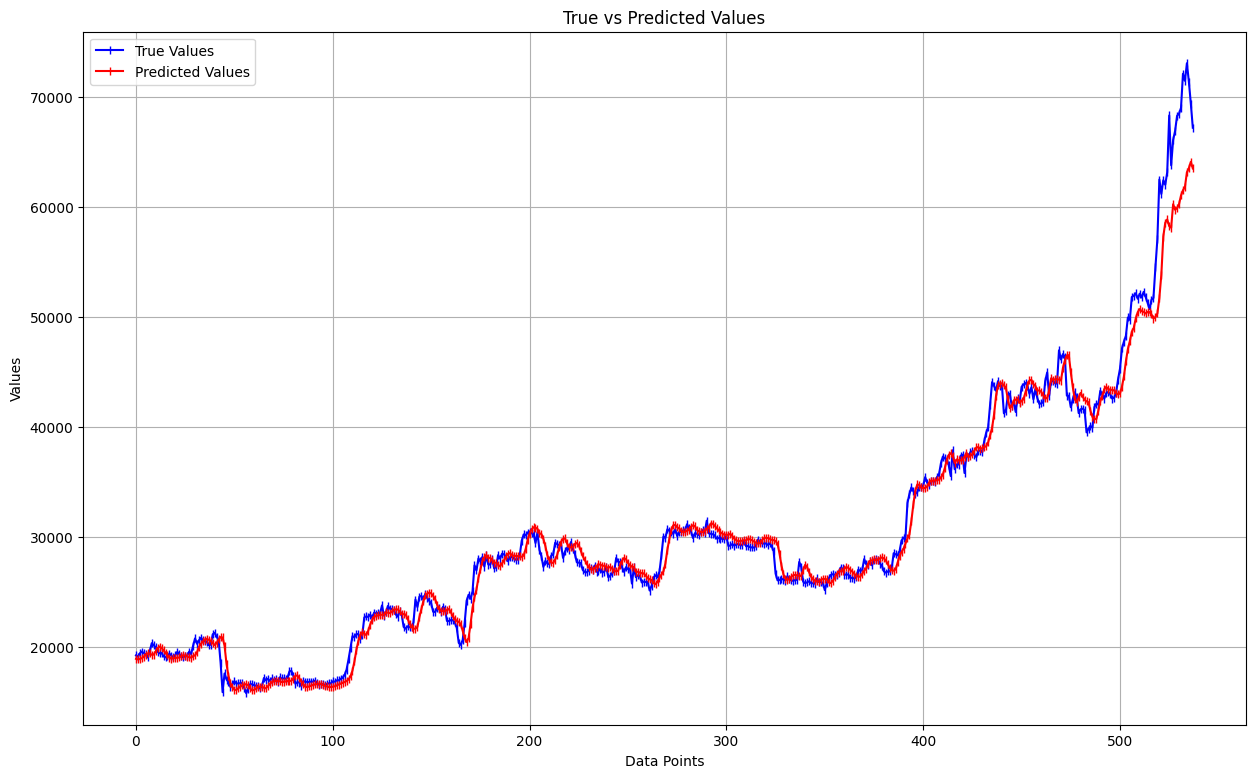

In [ ]:
plt.figure(figsize=(15,9))
plt.grid(True)
x_values = np.arange(len(y_test_inverse))
plt.plot(x_values, y_test_inverse, label='True Values', color='blue', linestyle='-', marker='|')
plt.plot(x_values, y_pred_inverse, label='Predicted Values', color='red',linestyle='-', marker='|')
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()


# ***=======================>GRU***

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping


timesteps = 30
num_features = X_train.shape[2]


model_gru = Sequential()
model_gru.add(GRU(units=100, return_sequences=False, input_shape=(timesteps, num_features)))
model_gru.add(Dense(1))


model_gru.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=['mape'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_gru.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

y_pred_gru = model_gru.predict(X_test)
mape_gru = mean_absolute_percentage_error(y_test, y_pred_gru)
print(f'Mean Absolute Percentage Error (MAPE): {mape_gru:.2f}%')


Epoch 1/100
75/75 [==============================] - 3s 10ms/step - loss: 0.0471 - mape: 29.9844 - val_loss: 0.0311 - val_mape: 12.6982
Epoch 2/100
75/75 [==============================] - 0s 5ms/step - loss: 0.0033 - mape: 13.3504 - val_loss: 0.0288 - val_mape: 13.8563
Epoch 3/100
75/75 [==============================] - 0s 5ms/step - loss: 0.0031 - mape: 11.5296 - val_loss: 0.0247 - val_mape: 12.7706
Epoch 4/100
75/75 [==============================] - 0s 5ms/step - loss: 0.0030 - mape: 11.3676 - val_loss: 0.0200 - val_mape: 11.3522
Epoch 5/100
75/75 [==============================] - 0s 5ms/step - loss: 0.0031 - mape: 11.5357 - val_loss: 0.0275 - val_mape: 14.0799
Epoch 6/100
75/75 [==============================] - 0s 5ms/step - loss: 0.0031 - mape: 10.4896 - val_loss: 0.0229 - val_mape: 12.1674
Epoch 7/100
75/75 [==============================] - 0s 5ms/step - loss: 0.0030 - mape: 11.0798 - val_loss: 0.0180 - val_mape: 10.4121
Epoch 8/100
75/75 [==============================] - 0

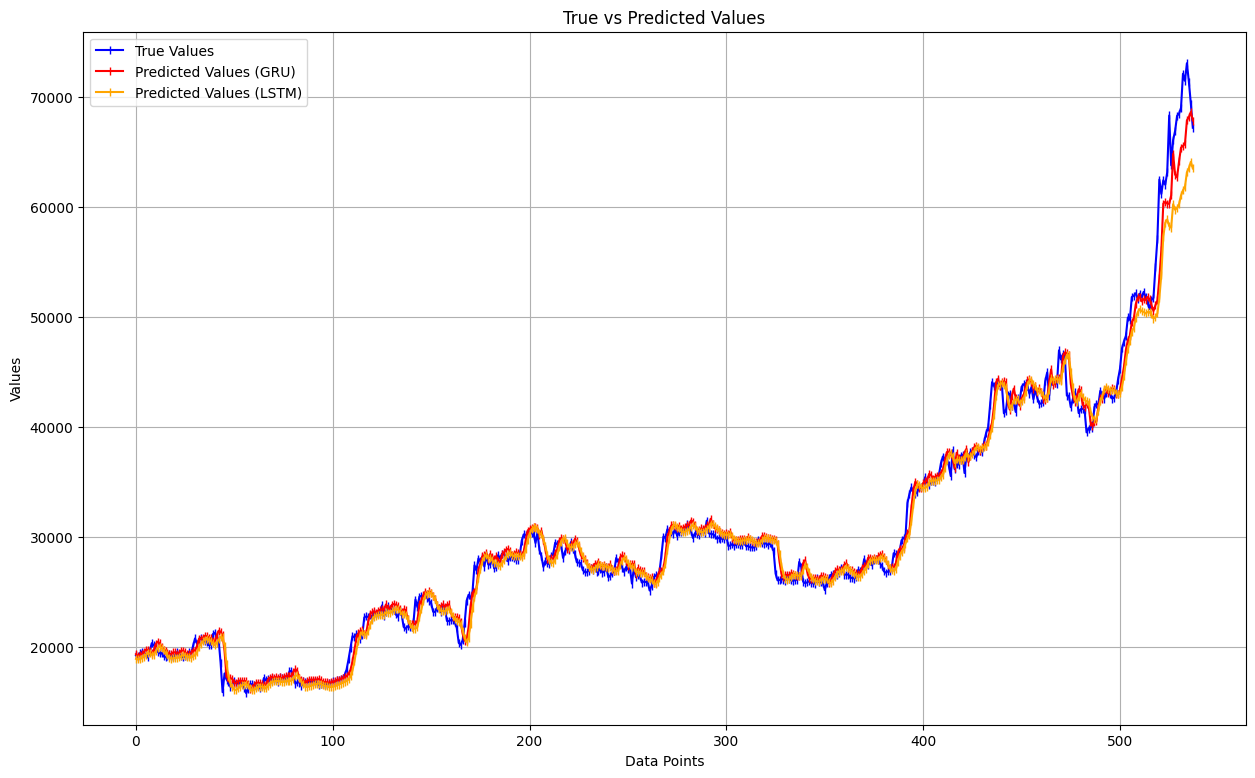

In [ ]:
y_pred_gru_inverse=scaler_y.inverse_transform(y_pred_gru.reshape(-1, 1))
plt.figure(figsize=(15,9))
plt.grid(True)
x_values = np.arange(len(y_test_inverse))
plt.plot(x_values, y_test_inverse, label='True Values', color='blue', linestyle='-', marker='|')
plt.plot(x_values, y_pred_gru_inverse, label='Predicted Values (GRU)', color='red',linestyle='-', marker='|')
plt.plot(x_values, y_pred_inverse, label='Predicted Values (LSTM)', color='orange',linestyle='-', marker='|')
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

# ***==============================>SVM***

In [ ]:
from sklearn.svm import SVR

X_train_reshaped = X_train.reshape(-1, 30)
model = SVR(kernel='rbf', C=200)
model.fit(X_train_reshaped, y_train)

X_val_reshaped = X_val.reshape(-1, 30)
X_test_reshaped = X_test.reshape(-1, 30)
y_pred_val = model.predict(X_val_reshaped)
y_pred_test = model.predict(X_test_reshaped)

mape_val = mean_absolute_percentage_error(y_val, y_pred_val)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print(f'MAPE on validation set: {mape_val:.2f}%')
print(f'MAPE on test set: {mape_test:.2f}%')


MAPE on validation set: 0.39%
MAPE on test set: 0.53%


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


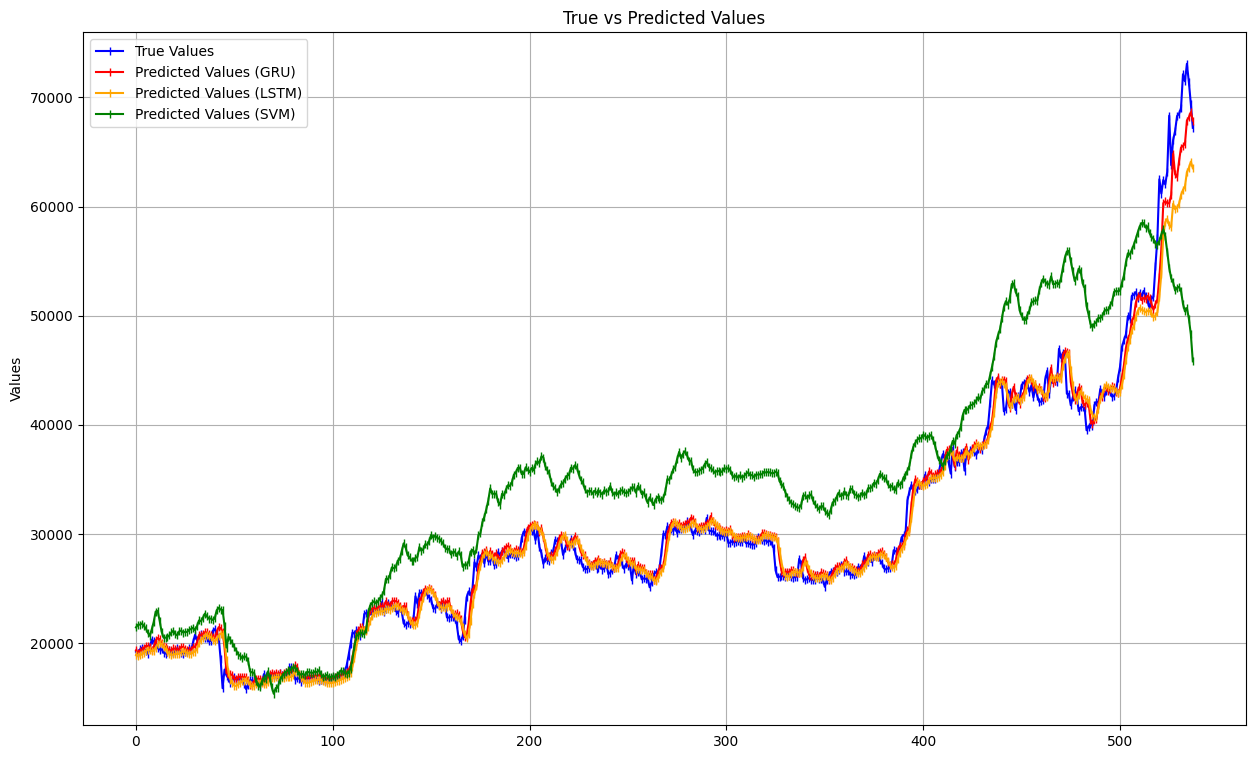

In [ ]:
y_pred_svm_inverse=scaler_y.inverse_transform(y_pred_test.reshape(-1, 1))
plt.figure(figsize=(15,9))
plt.grid(True)
x_values = np.arange(len(y_test_inverse))
plt.plot(x_values, y_test_inverse, label='True Values', color='blue', linestyle='-', marker='|')
plt.plot(x_values, y_pred_gru_inverse, label='Predicted Values (GRU)', color='red',linestyle='-', marker='|')
plt.plot(x_values, y_pred_inverse, label='Predicted Values (LSTM)', color='orange',linestyle='-', marker='|')
plt.plot(x_values, y_pred_svm_inverse, label='Predicted Values (SVM)', color='green',linestyle='-', marker='|')
plt.ylabel('Values')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

# ***======================>ARIMA***

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import warnings


warnings.filterwarnings("ignore")

train=X_normalized[:2900]
test= X_test
print('Total Test cases: {}'.format(len(test)))
predictions = []
mape = []

for t in range(len(test)):
    history = test[t]
    model = ARIMA(history, order=(0, 2, 2))
    model_fit = model.fit()

    output = model_fit.forecast(steps=1)
    yhat = output[0]
    predictions.append(yhat)

    actual = y_test[t]
    mape.append(np.abs((actual - yhat) / actual) * 100)

avg_mape = np.mean(mape)
print(model_fit.summary())
print("Average MAPE:", avg_mape)



Total Test cases: 538
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   30
Model:                 ARIMA(0, 2, 2)   Log Likelihood                  19.229
Date:                Sat, 16 Mar 2024   AIC                            -32.457
Time:                        20:53:36   BIC                            -28.460
Sample:                             0   HQIC                           -31.235
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.1997      0.593     -2.023      0.043      -2.362      -0.037
ma.L2          0.2103      0.128      1.639      0.101      -0.041       0.462
sigma2         0.0131      0.0

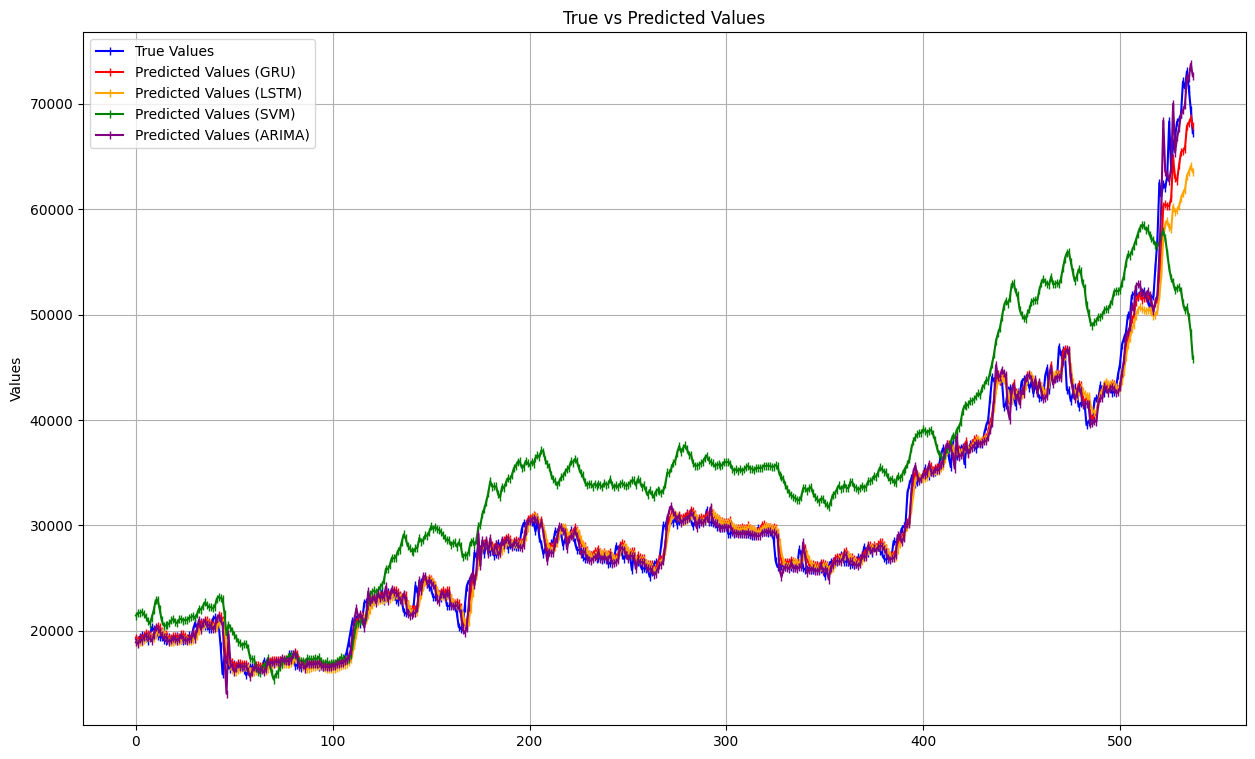

In [ ]:
import torch
predictions = torch.tensor(predictions)
y_pred_arima_inverse=scaler_y.inverse_transform(predictions.reshape(-1, 1))
plt.figure(figsize=(15,9))
plt.grid(True)
x_values = np.arange(len(y_test_inverse))
plt.plot(x_values, y_test_inverse, label='True Values', color='blue', linestyle='-', marker='|')
plt.plot(x_values, y_pred_gru_inverse, label='Predicted Values (GRU)', color='red',linestyle='-', marker='|')
plt.plot(x_values, y_pred_inverse, label='Predicted Values (LSTM)', color='orange',linestyle='-', marker='|')
plt.plot(x_values, y_pred_svm_inverse, label='Predicted Values (SVM)', color='green',linestyle='-', marker='|')
plt.plot(x_values, y_pred_arima_inverse, label='Predicted Values (ARIMA)', color='purple',linestyle='-', marker='|')
plt.ylabel('Values')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

# ***========================>Feature Enginnering & model training***

In [ ]:
window_size = [5,10,30]
for i in window_size:
    btc[f'SMA_{i}'] = btc['Close'].rolling(window=i).mean()
    btc[f'EMA_{i}'] = btc['Close'].ewm(span=i, adjust=False).mean()
btc=btc[max(window_size):-1]
btc

,Close,Volume,Target,SMA_5,EMA_5,SMA_10,EMA_10,SMA_30,EMA_30
Date,,,,,,,,,
2014-10-17 00:00:00+00:00,383.757996,13600700,391.441986,390.474200,384.683526,377.274704,379.236528,381.660267,387.415580
2014-10-18 00:00:00+00:00,391.441986,11416800,389.545990,390.679797,386.936346,381.124902,381.455702,380.560333,387.675348
2014-10-19 00:00:00+00:00,389.545990,5914570,382.845001,388.414996,387.806228,383.576901,382.926664,380.385333,387.796034
2014-10-20 00:00:00+00:00,382.845001,16419000,386.475006,386.029395,386.152485,385.705200,382.911816,379.516700,387.476613
2014-10-21 00:00:00+00:00,386.475006,14188900,383.157990,386.813196,386.259992,388.122800,383.559669,379.105167,387.411993
...,...,...,...,...,...,...,...,...,...
2024-03-11 00:00:00+00:00,72123.906250,65716656765,71481.289062,68973.631250,69175.733253,66830.379297,66725.126047,57833.513672,59285.542042
2024-03-12 00:00:00+00:00,71481.289062,62554434520,73083.500000,69884.792188,69944.251856,67775.523438,67589.882959,58606.426042,60072.364430
2024-03-13 00:00:00+00:00,73083.500000,48212536929,71396.593750,70841.473437,70990.667904,68767.136328,68588.722421,59377.268620,60911.792531


In [ ]:
from google.colab import files
from io import StringIO

uploaded = files.upload()
for filename in uploaded.keys():
    content = uploaded[filename].decode('utf-8')

df = pd.read_csv(StringIO(content), index_col=0)
df['edit_count'] = df['edit_count']
df.index = pd.to_datetime(df.index)



Saving wikipedia_edits.csv to wikipedia_edits.csv


In [ ]:
import pandas as pd
btc.index = btc.index.tz_localize(None)
data = pd.merge(btc, df, how='inner', left_index=True, right_index=True)

In [ ]:
data

,Close,Volume,Target,SMA_5,EMA_5,SMA_10,EMA_10,SMA_30,EMA_30,edit_count,sentiment,neg_sentiment
2014-10-17,383.757996,13600700,391.441986,390.474200,384.683526,377.274704,379.236528,381.660267,387.415580,8.266667,-0.290335,0.564434
2014-10-18,391.441986,11416800,389.545990,390.679797,386.936346,381.124902,381.455702,380.560333,387.675348,8.200000,-0.257586,0.531100
2014-10-19,389.545990,5914570,382.845001,388.414996,387.806228,383.576901,382.926664,380.385333,387.796034,8.533333,-0.287063,0.547767
2014-10-20,382.845001,16419000,386.475006,386.029395,386.152485,385.705200,382.911816,379.516700,387.476613,8.900000,-0.304917,0.556741
2014-10-21,386.475006,14188900,383.157990,386.813196,386.259992,388.122800,383.559669,379.105167,387.411993,8.966667,-0.301859,0.556741
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-11,72123.906250,65716656765,71481.289062,68973.631250,69175.733253,66830.379297,66725.126047,57833.513672,59285.542042,1.333333,-0.180856,0.284921
2024-03-12,71481.289062,62554434520,73083.500000,69884.792188,69944.251856,67775.523438,67589.882959,58606.426042,60072.364430,1.333333,-0.180856,0.284921
2024-03-13,73083.500000,48212536929,71396.593750,70841.473437,70990.667904,68767.136328,68588.722421,59377.268620,60911.792531,1.333333,-0.180856,0.284921
2024-03-14,71396.593750,59594605698,69403.773438,71421.015625,71125.976519,69073.754297,69099.244481,60099.073698,61588.231320,1.200000,-0.164037,0.259921


In [ ]:
target_column = 'Target'

X = []
y = []

for i in range(30, len(data)):
    close_values = data['Close'].iloc[i-30:i].values
    sma_value_5 = data['SMA_5'].iloc[i]
    ema_value_5 = data['EMA_5'].iloc[i]
    edit_count = data['edit_count'].iloc[i]
    sentiment = data['sentiment'].iloc[i]
    neg_sentiment = data['neg_sentiment'].iloc[i]
    feature_values = np.concatenate([close_values, [ sma_value_5, ema_value_5,edit_count,sentiment,neg_sentiment]])
    X.append(feature_values)
    y.append(btc[target_column].iloc[i])

X = np.array(X)
y = np.array(y)


In [ ]:
X.shape

(3408, 35)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler()
X_normalized = scaler_x.fit_transform(X)
scaler_y = StandardScaler()
y_normalized = scaler_y.fit_transform(y.reshape(-1, 1))
X_normalized = X_normalized.reshape((X.shape[0], X.shape[1], 1))
X_train, y_train = X_normalized[:2700], y_normalized[:2700]
X_val, y_val = X_normalized[2700:2900], y_normalized[2700:2900]
X_test, y_test = X_normalized[2900:], y_normalized[2900:]


In [ ]:
X_train.shape

(2700, 35, 1)

# ***====================>LSTM***

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(400, input_shape=(35, 1), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(200))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mape'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_val, y_val), callbacks=[early_stopping])

y_pred = model.predict(X_test)


Epoch 1/100
338/338 [==============================] - 8s 12ms/step - loss: 0.0298 - mape: 22.6657 - val_loss: 0.0134 - val_mape: 19.5275
Epoch 2/100
338/338 [==============================] - 3s 8ms/step - loss: 0.0135 - mape: 16.2290 - val_loss: 0.0122 - val_mape: 17.9286
Epoch 3/100
338/338 [==============================] - 3s 8ms/step - loss: 0.0139 - mape: 17.7100 - val_loss: 0.0350 - val_mape: 30.4972
Epoch 4/100
338/338 [==============================] - 3s 8ms/step - loss: 0.0130 - mape: 16.5922 - val_loss: 0.0235 - val_mape: 30.5145
Epoch 5/100
338/338 [==============================] - 3s 10ms/step - loss: 0.0137 - mape: 17.0450 - val_loss: 0.0068 - val_mape: 15.0018
Epoch 6/100
338/338 [==============================] - 3s 8ms/step - loss: 0.0126 - mape: 16.1034 - val_loss: 0.0177 - val_mape: 28.7662
Epoch 7/100
338/338 [==============================] - 3s 8ms/step - loss: 0.0134 - mape: 15.9459 - val_loss: 0.0062 - val_mape: 14.5234
Epoch 8/100
338/338 [==================

In [ ]:
y_pred_inverse = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1))
ErrorLstm = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)
print(f"Mean Absolute Percentage Error (MAPE): {ErrorLstm:.2f}%")


Mean Absolute Percentage Error (MAPE): 0.03%


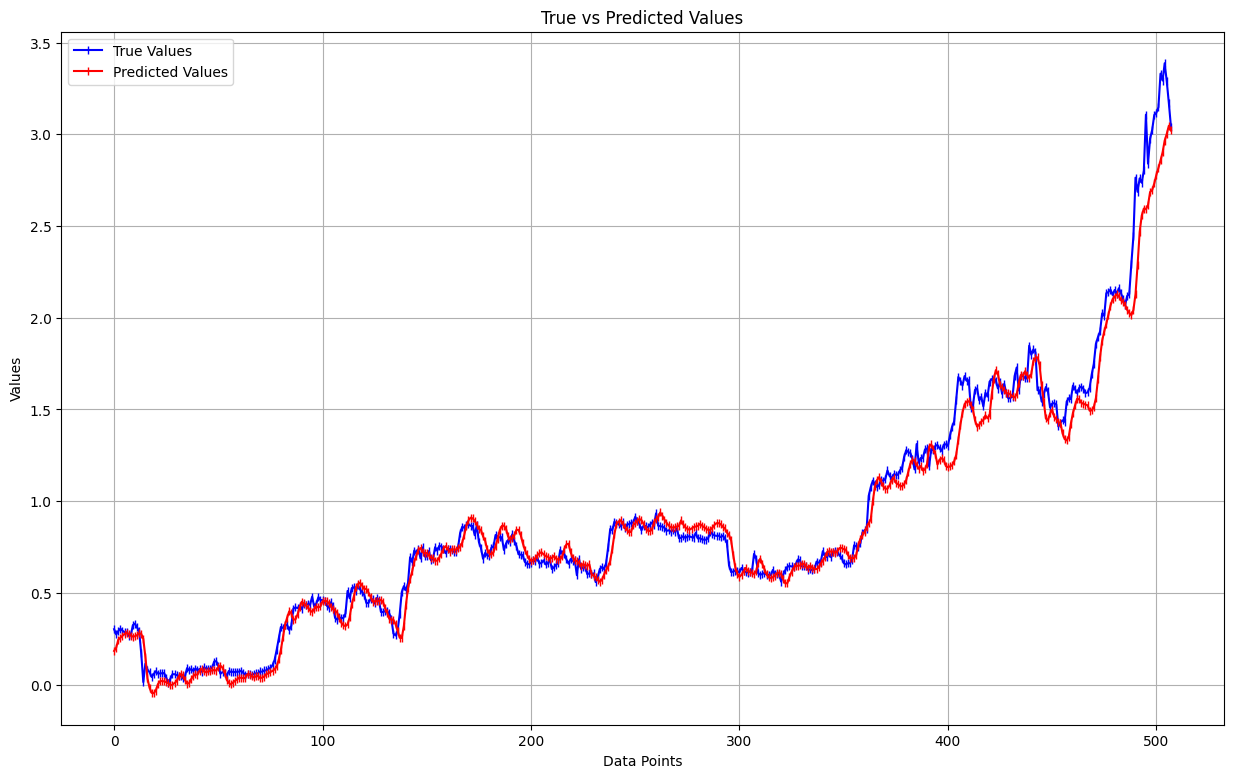

In [ ]:
plt.figure(figsize=(15,9))
plt.grid(True)
x_values = np.arange(len(y_test))
plt.plot(x_values, y_test, label='True Values', color='blue', linestyle='-', marker='|')
plt.plot(x_values, y_pred, label='Predicted Values', color='red',linestyle='-', marker='|')
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()


# ***=====================>GRU***

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping


timesteps = 35
num_features = X_train.shape[2]


model_gru = Sequential()
model_gru.add(GRU(units=100, return_sequences=False, input_shape=(timesteps, num_features)))
model_gru.add(Dense(1))


model_gru.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=['mape'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_gru.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

y_pred_gru = model_gru.predict(X_test)
mape_gru = mean_absolute_percentage_error(y_test, y_pred_gru)
print(f'Mean Absolute Percentage Error (MAPE): {mape_gru:.2f}%')


Epoch 1/100
85/85 [==============================] - 4s 10ms/step - loss: 0.1264 - mape: 34.1478 - val_loss: 0.0203 - val_mape: 19.8101
Epoch 2/100
85/85 [==============================] - 0s 5ms/step - loss: 0.0094 - mape: 15.3462 - val_loss: 0.0106 - val_mape: 15.6863
Epoch 3/100
85/85 [==============================] - 0s 5ms/step - loss: 0.0063 - mape: 12.0017 - val_loss: 0.0187 - val_mape: 24.4949
Epoch 4/100
85/85 [==============================] - 0s 5ms/step - loss: 0.0056 - mape: 12.0943 - val_loss: 0.0141 - val_mape: 21.0545
Epoch 5/100
85/85 [==============================] - 0s 6ms/step - loss: 0.0053 - mape: 11.7964 - val_loss: 0.0061 - val_mape: 13.5615
Epoch 6/100
85/85 [==============================] - 0s 5ms/step - loss: 0.0066 - mape: 12.7471 - val_loss: 0.0091 - val_mape: 17.2426
Epoch 7/100
85/85 [==============================] - 0s 5ms/step - loss: 0.0052 - mape: 12.1499 - val_loss: 0.0088 - val_mape: 16.4169
Epoch 8/100
85/85 [==============================] - 0

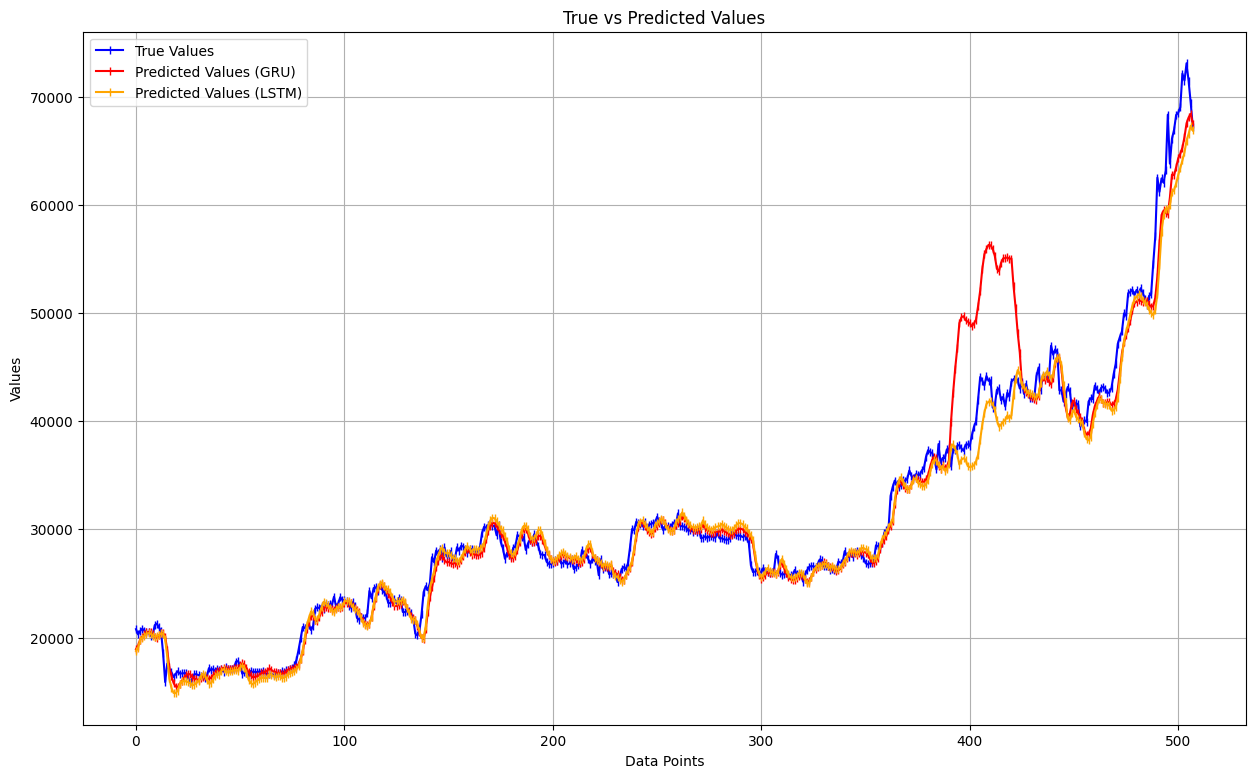

In [ ]:
y_pred_gru_inverse=scaler_y.inverse_transform(y_pred_gru.reshape(-1, 1))
plt.figure(figsize=(15,9))
plt.grid(True)
x_values = np.arange(len(y_test_inverse))
plt.plot(x_values, y_test_inverse, label='True Values', color='blue', linestyle='-', marker='|')
plt.plot(x_values, y_pred_gru_inverse, label='Predicted Values (GRU)', color='red',linestyle='-', marker='|')
plt.plot(x_values, y_pred_inverse, label='Predicted Values (LSTM)', color='orange',linestyle='-', marker='|')
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

# ***======================>SVM***

In [ ]:
from sklearn.svm import SVR

X_train_reshaped = X_train.reshape(-1, 35)
model = SVR(kernel='rbf', C=200)
model.fit(X_train_reshaped, y_train)

X_val_reshaped = X_val.reshape(-1, 35)
X_test_reshaped = X_test.reshape(-1, 35)
y_pred_val = model.predict(X_val_reshaped)
y_pred_test = model.predict(X_test_reshaped)

mape_val = mean_absolute_percentage_error(y_val, y_pred_val)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print(f'MAPE on validation set: {mape_val:.2f}%')
print(f'MAPE on test set: {mape_test:.2f}%')


MAPE on validation set: 0.32%
MAPE on test set: 0.29%


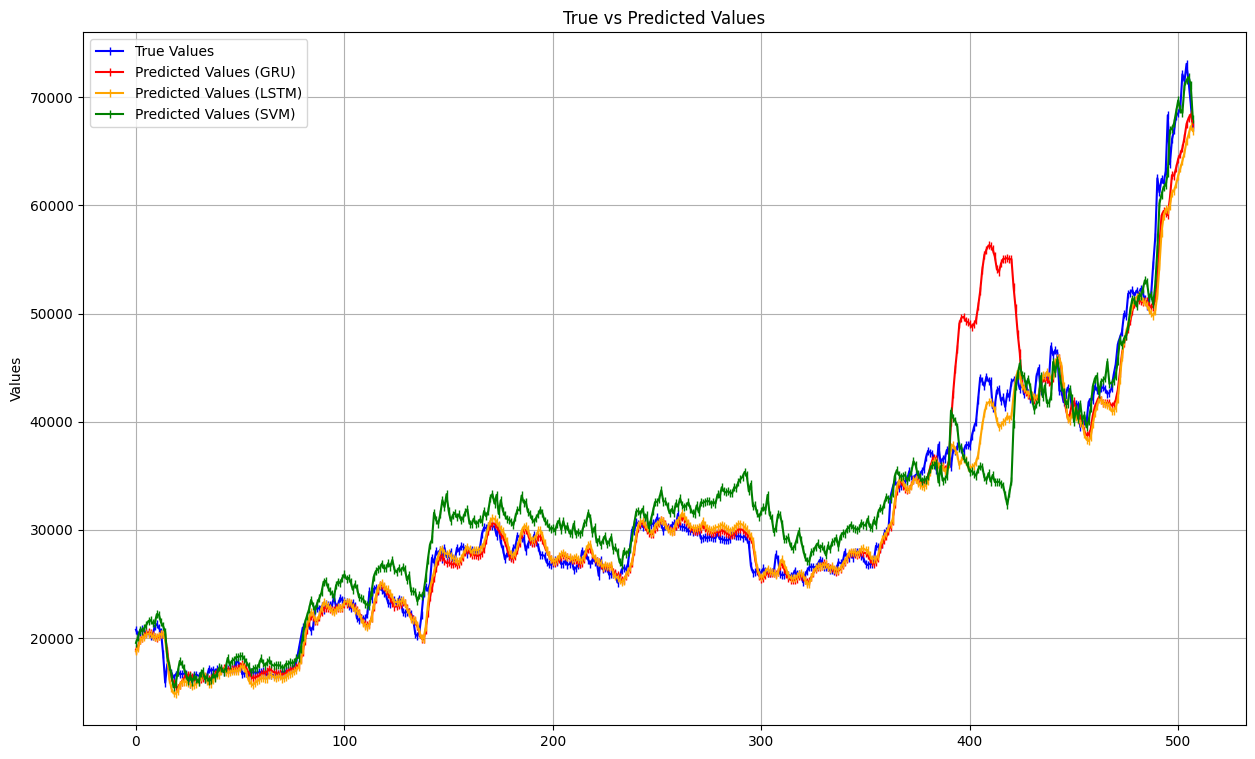

In [ ]:
y_pred_svm_inverse=scaler_y.inverse_transform(y_pred_test.reshape(-1, 1))
plt.figure(figsize=(15,9))
plt.grid(True)
x_values = np.arange(len(y_test_inverse))
plt.plot(x_values, y_test_inverse, label='True Values', color='blue', linestyle='-', marker='|')
plt.plot(x_values, y_pred_gru_inverse, label='Predicted Values (GRU)', color='red',linestyle='-', marker='|')
plt.plot(x_values, y_pred_inverse, label='Predicted Values (LSTM)', color='orange',linestyle='-', marker='|')
plt.plot(x_values, y_pred_svm_inverse, label='Predicted Values (SVM)', color='green',linestyle='-', marker='|')
plt.ylabel('Values')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

# ***===================>ARIMA***

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import warnings


warnings.filterwarnings("ignore")

train=X_normalized[:2900]
test= X_test
print('Total Test cases: {}'.format(len(test)))
predictions = []
mape = []

for t in range(len(test)):
    history = test[t]
    model = ARIMA(history, order=(0, 2, 2))
    model_fit = model.fit()

    output = model_fit.forecast(steps=1)
    yhat = output[0]
    predictions.append(yhat)

    actual = y_test[t]
    mape.append(np.abs((actual - yhat) / actual) * 100)

avg_mape = np.mean(mape)
print(model_fit.summary())
print("Average MAPE:", avg_mape)



Total Test cases: 508
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   35
Model:                 ARIMA(0, 2, 2)   Log Likelihood                 -33.275
Date:                Sat, 16 Mar 2024   AIC                             72.551
Time:                        21:00:57   BIC                             77.040
Sample:                             0   HQIC                            74.061
                                 - 35                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.1218      0.532     -2.108      0.035      -2.165      -0.079
ma.L2          0.3518      0.716      0.491      0.623      -1.051       1.755
sigma2         0.4212      0.0

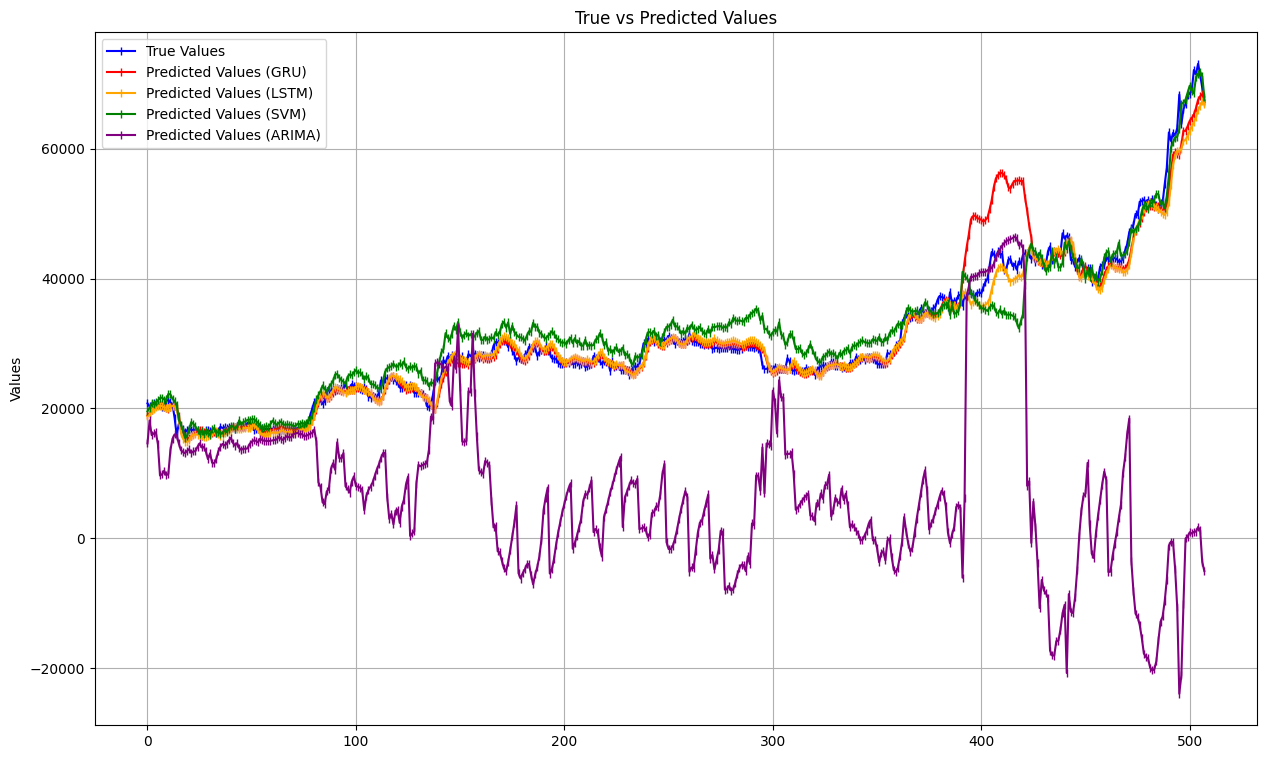

In [ ]:
import torch
predictions = torch.tensor(predictions)
y_pred_arima_inverse=scaler_y.inverse_transform(predictions.reshape(-1, 1))
plt.figure(figsize=(15,9))
plt.grid(True)
x_values = np.arange(len(y_test_inverse))
plt.plot(x_values, y_test_inverse, label='True Values', color='blue', linestyle='-', marker='|')
plt.plot(x_values, y_pred_gru_inverse, label='Predicted Values (GRU)', color='red',linestyle='-', marker='|')
plt.plot(x_values, y_pred_inverse, label='Predicted Values (LSTM)', color='orange',linestyle='-', marker='|')
plt.plot(x_values, y_pred_svm_inverse, label='Predicted Values (SVM)', color='green',linestyle='-', marker='|')
plt.plot(x_values, y_pred_arima_inverse, label='Predicted Values (ARIMA)', color='purple',linestyle='-', marker='|')
plt.ylabel('Values')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()